

<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Advanced Dimensionality Reduction: SVD & Dictionary Learning

#### Misael M. Morales
#### Hildebrand Department of Petroleum & Geosystems Engineering, The University of Texas at Austin

### PGE 383 Subsurface Machine Learning, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Ademide Mabadeje, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/ademidemabadeje/)


### Executive Summary
Subsurface spatial data is often very large and difficult to process and utilize in machine learning workflows. Moreover, there tends to be high degrees of correlation and structure in 2D subsurface data, which makes it a perfect candidate for latent structure analysis and modeling. 

Here, we will utilize a 2D multivariate subsurface dataset and demonstrate the usage of **Singular Value Decomposition** and **Dictionary Learning** to encode the data into the latent space and then reconstruct using a fraction of the original size. Singular Value Decomposition works by decomposing the data matrix into three components: left-singular vectors, singular values, and right-singular vectors. We can then project onto the first few singular values/vectors to obtain a reduced-dimensionality representation of the data, and use this new feature space to approximately reconstruct our images. In Dictionary Learning, we construct a set of atoms/words that sparsely represent the data through a singular value-type representation, and can use this set of atoms to selectively to reconstruct our images, thus reducing the latent dimension of the problem.

We learn that using SVD, different latent dimensions will result in different degrees of lossy reconstruction, but that this method is efficient, economic, and simple enough to treat our large data into a reduced dimensionality form. We recommend to use this autoencoder structure whenever dealing with image or volume problems in order to reduce redundancy and increase efficiency of our machine learning workflows.

### Table of Contents
1. Import Packages </br>
2. Declare Functions </br>
3. Load & Preprocess Data </br>
    a) MNIST Data </br>
    b) Subsurface Data

4. Dimensionality Reduction </br>
    a) Singular Value Decomposition (SVD) </br>
    b) Dictionary Learning (kSVD)

***

### 1. Import Packages

We start by importing our most basic packages:

In [1]:
%matplotlib inline
import numpy as np                     #arrays and matrix math
import pandas as pd                    #DataFrames management and indexing
import matplotlib.pyplot as plt        #plotting and visualization
import matplotlib.gridspec as gridspec #enhanced subplot referencing
import tensorflow as tf                #deep learning functionality and MNIST data

Import other important packages for preprocessing, metrics, etc., and project-specific packages and functions

In [2]:
# Feature Engineering/Preprocessing
from sklearn.preprocessing import MinMaxScaler                #Normalize variables to be in [0,1]
from scipy.interpolate import Rbf as Rbf_interpolation        #Inteprolate 2D map from sparse data

# Goodness-of-Fit Metrics
from sklearn.metrics import mean_squared_error                #Mean squared error (MSE)
from skimage.metrics import structural_similarity as SSIM     #Structural Similarity Index (SSIM)

# Project-specific
from numpy.linalg import svd as SVD                           #Singular Value Decomposition
from sklearn.decomposition import DictionaryLearning          #Sparse encoding using dictionary of atoms
from sklearn.decomposition import MiniBatchDictionaryLearning #Sparse encoding using dictionary (mini-batch formulation)
from sklearn.decomposition import SparseCoder                 #Sparse reconstruction using dictionary of atoms

### 2. Delcare Functions
The following functions will be used in the workflow.

In [3]:
# Plot function for sample images
def plot_sample_matrix(samples, my_cmap):
    num_samples, x_dim, y_dim, _ = samples.shape
    axes = (np.round(np.sqrt(num_samples))).astype(int)
    fig  = plt.figure(figsize=(axes, axes))
    gs   = gridspec.GridSpec(axes, axes)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off'); ax.set_aspect('equal')
        plt.imshow(sample, cmap=my_cmap)

This variable will help us when inserting text boxes into our matplotlib plots

In [4]:
# Define arguments for text box in PLT.TEXT()
my_box = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

This next function is optional, and will simply be a check that your current version of tensorflow on your Python kernel is running on a GPU and if tensorflow is built with CUDA.

In [5]:
# Check tensorflow GPU settings
print('Tensorflow built with CUDA? ',  tf.test.is_built_with_cuda())
tf.config.list_physical_devices()

Tensorflow built with CUDA?  True


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

### 3. Load & Preprocess Data

We will deal with two different datasets, both of which need preprocessing.

(1) MNIST dataset: handwritten digits as $28x28$ images from *tensorflow* </br>
(2) Subsurface multivariate data: 2D spatial (sparse) data

### 3. a) MNIST Data

This is a set of $60,000$ images of handwritten digits $0$-$9$. We load it directly from *tensorflow* datasets ([link](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist)), and will preprocess to center and flatten as needed for our techniques.

In [6]:
# Load the Dataset and split into train/test
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.mnist.load_data()

# Choose to work with ALL or only a few (N) MNIST images (full size is 60,000)
#N = len(x_train_all)
N = 5000
x_train, x_test = x_train_all[:N], x_test_all[:N]
y_train, y_test = y_train_all[:N], y_test_all[:N]

# Normalize the Images
x_train = np.expand_dims(x_train/255.0, axis=-1)
x_test  = np.expand_dims(x_test/255.0, axis=-1)

# Define the labels
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

# Print the shapes of the training and testing sets + check that training images are normalized
print('MNIST dataset properties:')
print('Train || Shapes: X={}, Y={} | min={}, max={}'.format(x_train.shape, y_train.shape, x_train.min(), x_train.max()))
print('Test  || Shapes: X={}, Y={} | min={}, max={}'.format(x_test.shape, y_test.shape, x_test.min(), x_test.max()))

MNIST dataset properties:
Train || Shapes: X=(5000, 28, 28, 1), Y=(5000,) | min=0.0, max=1.0
Test  || Shapes: X=(5000, 28, 28, 1), Y=(5000,) | min=0.0, max=1.0


In [7]:
# Flatten and Center the images
print('Flattened and Center Images:')

# Flatten the images into NxM array
x_train_f = np.transpose(np.reshape(x_train, [x_train.shape[0], -1]))
x_test_f  = np.transpose(np.reshape(x_test, [x_test.shape[0], -1]))

# Center the Flattened images
x_train_f_c = x_train_f - np.expand_dims(np.mean(x_train_f, axis=1), axis=1)
x_test_f_c  = x_test_f - np.expand_dims(np.mean(x_test_f, axis=1), axis=1)

print('Train || Shapes: X={}, Y={} | min={:.3f}, max={:.3f}'.format(x_train_f_c.shape, y_train.shape, x_train_f_c.min(), x_train_f_c.max()))
print('Test  || Shapes: X={}, Y={} | min={:.3f}, max={:.3f}'.format(x_test_f_c.shape, y_test.shape, x_test_f_c.min(), x_test_f_c.max()))

Flattened and Center Images:
Train || Shapes: X=(784, 5000), Y=(5000,) | min=-0.549, max=1.000
Test  || Shapes: X=(784, 5000), Y=(5000,) | min=-0.531, max=1.000


For improved visualization, we will define a new colormap that uses the 10 individual digits ($0$-$9$) and implement the '*jet*' colormap.

In [8]:
# Define a colormap for the 10-class classification system
import matplotlib.cm as cm
from matplotlib.colors import Normalize
my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=9)
cs      = my_cmap(my_norm(y_train))

Next, we will count the number of items that is in each of the 10 digit categories, and also visualize the first few samples from the training and testing dataset.

In [9]:
# Count the number of occurrences for each digit within the training/testing datasets
digit_count = {}
for i in np.arange(len(class_names)):
    digit_count[i] = x_train[y_train==i].shape[0]
digit_count = pd.DataFrame(list(digit_count.values()), columns=['Count']).T
print('Count per Digit:')
digit_count.head()

Count per Digit:


,0,1,2,3,4,5,6,7,8,9
Count,479,563,488,493,535,434,501,550,462,495


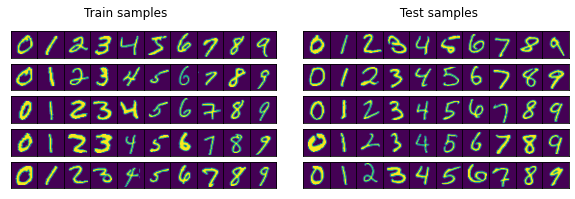

In [10]:
# Visualize a few Train/Test samples from mnist
fig = plt.figure(figsize=(10, 3), constrained_layout=False)
fig.suptitle('Train samples'+60*' '+'Test samples')
outer_grid = fig.add_gridspec(1, 2, wspace=0.1, hspace=0)

left_grid = outer_grid[0, 0].subgridspec(5, 10, wspace=0, hspace=0)
axs = left_grid.subplots() 
for (c,d), ax in np.ndenumerate(axs):
    ax.imshow(x_train[y_train==d][c]); ax.set(xticks=[], yticks=[])
    
right_grid = outer_grid[0, 1].subgridspec(5, 10, wspace=0, hspace=0)
axs = right_grid.subplots() 
for (c,d), ax in np.ndenumerate(axs):
    ax.imshow(x_test[y_test==d][c]); ax.set(xticks=[], yticks=[])
    
plt.show();

### 3. b) Subsurface Data

The following workflow applies the .csv file 'spatial_nonlinear_MV_facies_v1.csv', a synthetic dataset calculated with geostatistical cosimulation by Dr. Michael Pyrcz, The University of Texas at Austin. The dataset is publically available [here](https://github.com/GeostatsGuy/GeoDataSets)  

From this site, other datasets can also be used for this workflow including but not limited to: {'spatial_nonlinear_MV_facies_v5.csv', 'sample_data_MV_biased.csv', 'PGE383_Dataset_13_Wells.csv', '12_sample_data.csv'}.

We will work with the following features:

* **X** and **Y** - the sptial coordinates (in meters) for the subsurface data
* **Porosity** - fraction of rock void in units of percentage
* **Permeability** - ability of a fluid to flow through the rock in milliDarcy
* **Acoustic Impedence** - product of sonic velocity and rock density (in $kg/m^2s*10^3$)
* **Facies** - binary indicator of sand or shale facies

In [11]:
# Select a subsurface Dataset for image reconstruction
df = pd.read_csv("https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/spatial_nonlinear_MV_facies_v1.csv")
df.head() #visualize first few rows of the DataFrame

,Index,X,Y,Porosity,Perm,AI,Facies
0,847,765.785293,326.858902,17.235937,470.678224,3875.081273,1
1,242,900.471904,620.461606,20.362213,638.279517,3903.808828,1
2,719,645.071599,206.330298,7.341895,214.431925,4683.320716,0
3,836,766.695572,655.100546,4.961607,151.320297,5178.398984,0
4,1114,1005.032808,235.545797,13.165391,413.035749,3993.382055,1


We perform normalization of the features by applying Min-Max scaling of the features such that:

$$ x^* = \frac{x-min(x)}{max(x)-min(x)} $$

where $min(x)$ and $max(x)$ are the minimum and maximum values for each of the features in the dataset.

This is done by the *scikitlearn* built-in function
``` python
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
scaled_array   = min_max_scaler.fit_transform(float_array)
```

In [12]:
scaler = MinMaxScaler()                           #instantiate the normalization function
df_s = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)  #apply min-max scaling
df_s.describe().T                           #show summary statistics of the new DataFrame

,count,mean,std,min,25%,50%,75%,max
Index,457.0,0.447638,0.300826,0.0,0.184821,0.410714,0.711607,1.0
X,457.0,0.539901,0.293454,0.0,0.298525,0.576053,0.790115,1.0
Y,457.0,0.519437,0.285332,0.0,0.289513,0.530998,0.773822,1.0
Porosity,457.0,0.450309,0.204280,0.0,0.295265,0.460446,0.583979,1.0
Perm,457.0,0.337283,0.190681,0.0,0.212090,0.344085,0.449092,1.0
AI,457.0,0.244481,0.166249,0.0,0.131160,0.205038,0.307400,1.0
Facies,457.0,0.787746,0.409352,0.0,1.000000,1.000000,1.000000,1.0


For simplicity, we specifically name our subsurface features/properties.

We also specifically name the *matplotlib* colormaps that we want to use for each of the feautures/properties.

In [13]:
features = ['Porosity','Perm','AI','Facies']       # names of our features
my_maps  = ['magma', 'jet', 'seismic', 'viridis']  # names of the corresponding colormaps

However, this is a **sparse** dataset of the subsurface, with 457 wells in approximately $1 km^2$ area of the subsurface. Therefore, we must interpolate the spatial properties so that we obtain a full image of the subsurface properties. 

The 2D interpolation is done through *scipy*'s RBF interpolation function. This generates radial basis function inteprolation from $(N,D)$ arrays to an $(M,D)$ domain.

We will interpolate the subsurface 2D data into $(28,28)$ images. These are the standard dimensions of the MNIST dataset, a generic dataset of handwritten digits that we will use later for our workflow.

In [14]:
# Interpolate spatial properties
ti = np.linspace(start=0, stop=1, num=28) #an array of 28 discrete points
XI, YI = np.meshgrid(ti,ti)               #a mesh of 28x28 discrete points
ZI = {}; ZI_s = {}                        

for i in features:
    # RBF interpolation
    ZI[i] = Rbf_interpolation(df_s['X'], df_s['Y'], df[i], function='thin_plate')(XI, YI)[::-1] 
    # Normalize our interpolated features 
    ZI_s[i]  = scaler.fit_transform(ZI[i])                                                           

for i in np.arange(len(features)):
    print(features[i]+': Shape={}, min={:.3f}, max={:.3f}'.format(ZI_s[features[i]].shape, 
                                                                  ZI_s[features[i]].min(), 
                                                                  ZI_s[features[i]].max()))

Porosity: Shape=(28, 28), min=0.000, max=1.000
Perm: Shape=(28, 28), min=0.000, max=1.000
AI: Shape=(28, 28), min=0.000, max=1.000
Facies: Shape=(28, 28), min=0.000, max=1.000


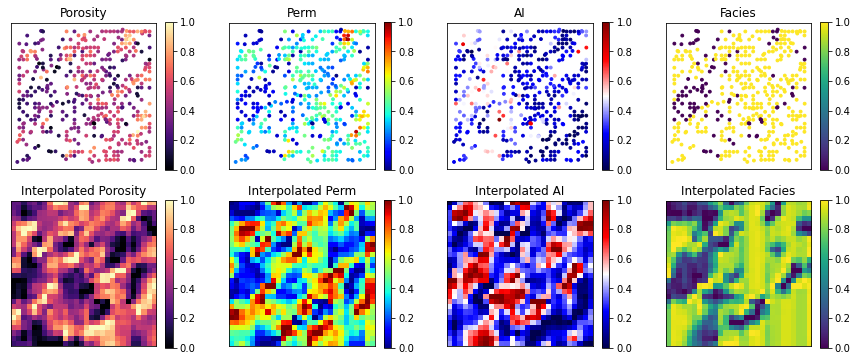

In [15]:
fig, axs = plt.subplots(2,4, figsize=(15,6))
for i in range(len(features)):
    axs[0,i].set_title(features[i]); axs[1,i].set_title('Interpolated '+features[i])
    # plot original data scatterplots
    im1 = axs[0,i].scatter(x=df_s['X'], y=df_s['Y'], s=8, c=df_s[features[i]], cmap=my_maps[i])
    fig.colorbar(im1, ax=axs[0,i])
    # plot interpolated images
    im2 = axs[1,i].imshow(ZI_s[features[i]], cmap=my_maps[i])
    fig.colorbar(im2, ax=axs[1,i])
    # remove ticks, set square box ratios
    for k in range(2):
        axs[k,i].set_xticks([]); axs[k,i].set_yticks([]); 
        axs[k,i].set_aspect('equal', adjustable='box')
plt.show();

Select one of the subsurface features to be used in the remainder of the notebook for image reconstruction.

In [16]:
# Select one of the subsruface features to work with
feature_selected = 'AI'

***

### 4. Advanced Dimensionality Reduction

Dimensionality Reduction is quite ubiqutuous in modern machine learning. PCA has been widely-studied and applied in theoretical and applied setting for data science, including reservoir characterization, modeling, and simulation. However, PCA assumes linearity and no outliers, while  SVD will simply decompose the matrix into left-and-right singular vectors and a diagonal singular value matrix. With this, we can project our 2D data onto the vectors and work in latent space.

Another consideration is the idea of using the latent space for a generic dataset as the basis for reconstruction of a more complex dataset. For instance, using the SVD decomposition of the $60,000$ MNIST images, we can reconstruct our 2D subsurface maps from a latent represenation!

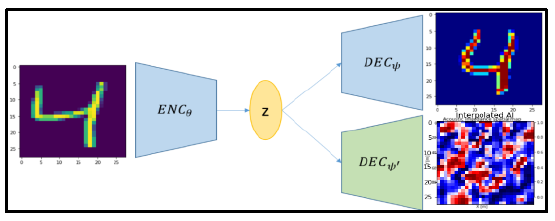

### 4. a) Singular Value Decomposition (SVD)

We start by implementing SVD on our MNIST dataset to obtain our singular values and right-and-left singular vectors. With this, we only select a subset such that we encode our matrices onto the latent space and work with a reduced dimensionality problem. Then we reconstruct our images from the inverse encoders using only $k$-dimensional latent vector, and analyze the results:

Singular Value Decomposition is given by:
        $$ X = U \Sigma V^* $$
where for a given data matrix $X \in \mathbb{C}^{(n\times m)}$ we have:
$U$ and $V$ are the left-singular $(n\times n)$ and right-singular $(m\times m)$ vectors, respectively, and $\Sigma$ is the non-negative, diagonal matrix $(n\times m)$ of ranked singular values, $\sigma_i = \Sigma_{ii}$. The amount of non-zero singular values equals the rank of $X$. Moreover, these singular values are sorted in descending order automatically. 
If $X$ is a real matrix, then $U$ and $V$ are guaranteed to be real orthogonal matrices; and SVD simply becomes: $X=U\Sigma V^T$. 

For a correlated dataset, we can compute an Economy, Truncated, or Compact-SVD such that we obtain:
        $$ X \approx \hat{U} \hat{\Sigma} \hat{V}^* = \hat{X}$$
where $\hat{\bullet}$ represents the first $k$ leading columns or block of the decomposition elements. Here, $\hat{U}$ is an $(m\times k)$ semi-unitary matrix and $V$ is an $(n\times k)$ semi-unitary matrix as well, such that: $U^*U = V^*V = I$, the identity matrix.

Note that $k$ will fundamentally depend on the rank of the matrix $X$ such that $k\leq\min{(m,n)}$. Compact SVD performed by only removing the $0$ singular values will not results in lossy compression, but further dimensionality reduction by only keeping the leading $k$ singular values will result in some level of loss.

For reconstruction using the latent space variables, it then follows that: $ \tilde{X}_{test} = \sum\limits_{i=1}^{k}\alpha_i\tilde{u}_i=\tilde{U}\alpha$, where $\alpha_i$ are the coefficients tht can be estimated to give the best MSE approximation. Then: $ \tilde{U}^*x_{test} = \tilde{U}^*\tilde{U}\alpha=\alpha \Longrightarrow \tilde{x}_{test}=\tilde{U}\tilde{U}^*x_{test}$.

In [17]:
# Perform Singular value decomsposition on our MNIST data (flat, centered)
U, S, VT = SVD(x_train_f_c, full_matrices=False)   #full_matrices=False -> economy SVD
S = np.diag(S)                                     #re-diagonalize S

print('Shapes: U={}, S={}, VT={}'.format(U.shape, S.shape, VT.shape))

Shapes: U=(784, 784), S=(784, 784), VT=(784, 5000)


With our transformation matrix, lets select and visualize the first few $k$ left-singular vectors (which will be used for our projection and prediction later).

In [18]:
# Define how many singular values/vectors we want to keep
k = 36

We can see how the choice of retaining $k$ singular values value compares to the general shape of the singular values in our data matrix, in terms of the relative cumulative singular value sum.

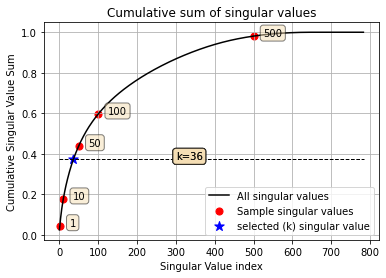

In [19]:
ks = [1, 10, 50, 100, 500]
S_ = np.cumsum(np.diag(S))/np.sum(np.diag(S))  # make it singular value "relative"

plt.figure()
plt.plot(S_, c='k', label='All singular values')
plt.scatter(ks, S_[ks], s=50, c='r', label='Sample singular values')
plt.hlines(S_[k], 0, 784, color='k', linestyle='--', linewidth=1)
plt.scatter(k, S_[k], c='b', marker='*', s=100, label='selected (k) singular value')
for j in ks:
    plt.text(j+25, S_[j], j, bbox=my_box)
    plt.text(300, S_[k], 'k='+str(k), bbox=my_box)
plt.title('Cumulative sum of singular values'); plt.grid('on')
plt.xlabel('Singular Value index'); plt.ylabel('Cumulative Singular Value Sum')
plt.legend(loc='lower right')
plt.show();

U_ shape: (36, 28, 28, 1)


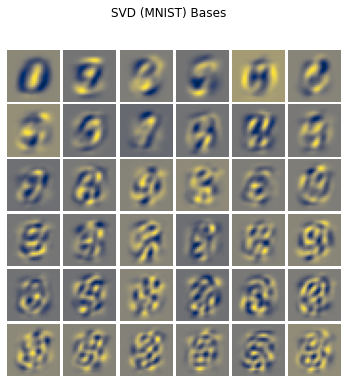

In [20]:
# Visualize the first "k" left-singular vectors
#reshape basis onto 28x28 images for visualization before plotting
U_ = np.reshape(U[:, :k].T, (-1, x_train.shape[1], x_train.shape[2], 1))
print('U_ shape:', U_.shape)
plot_sample_matrix(U_, my_cmap='cividis')
plt.suptitle('SVD (MNIST) Bases')
plt.show();

We now project our $60,000$ MNIST digits onto the left-singular vector latent space $U$ and compute the transpose of the (pseudo) inverse of this matrix to obtain our latent representations.

In [21]:
# Project onto k basis
v = (np.linalg.pinv(U[:, :k]) @ x_train_f_c).T

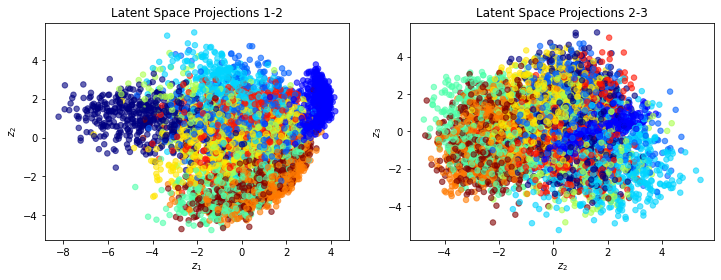

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(v[:, 0], v[:, 1], s=30, c=cs, alpha=0.6)
plt.xlabel('$z_1$'); plt.ylabel('$z_2$'); 
plt.title('Latent Space Projections 1-2')
plt.subplot(1, 2, 2)
plt.scatter(v[:, 1], v[:, 2], s=30, c=cs, alpha=0.6)
plt.xlabel('$z_2$'); plt.ylabel('$z_3$'); 
plt.title('Latent Space Projections 2-3')
plt.show();

With this latent representation, we can now reconstruct into our predicted images using the first $k$ basis and projected back with $V^T$ to form $\tilde{X}=\tilde{U}\tilde{\Sigma}\tilde{V}^T$.

In [23]:
# (TRAIN) Reconstruct using k basis
x_train_f_c_hat = U[:, :k] @ v.T                                                     #project
x_train_f_hat = x_train_f_c_hat + np.expand_dims(np.mean(x_train_f, axis=1), axis=1) #uncenter
x_train_hat = np.reshape(x_train_f_hat.T, [-1, 28, 28])                              #unflatten

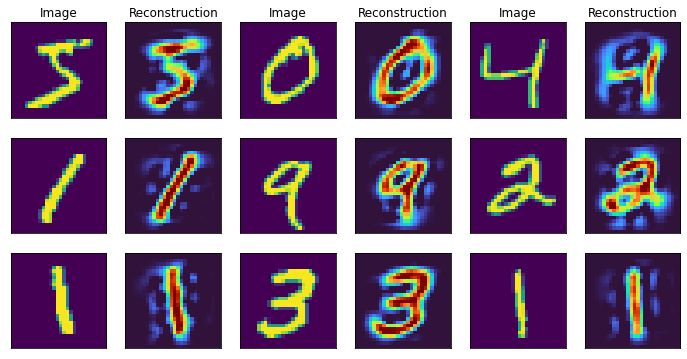

In [24]:
num_rows, num_cols = 3, 3
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_rows*num_cols):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plt.grid(False); plt.xticks([]); plt.yticks([])
    plt.imshow(x_train[i], vmin=0, vmax=1, cmap='viridis')
    if i < 3: plt.title('Image')
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plt.grid(False); plt.xticks([]); plt.yticks([])
    plt.imshow(x_train_hat[i], vmin=0, vmax=1, cmap='turbo')
    if i < 3: plt.title('Reconstruction')
plt.show();

We now have predicted images $\hat{x}$ for our MNIST dataset. Essentially, the decoded images from a truncated latent represenation obtained from SVD.

We will visualize these reconstructed images, and compare their quality by means of pixel-wise MSE and SSIM. Where:
    $$ MSE = \frac{1}{n} \sum\limits_{i=1}^{n}(y_i-\hat{y}_i)^2$$
and
    $$ SSIM(x,y) = \frac{(2\mu_x\mu_y+c_1)(2\sigma_{xy}+c_2)}{(\mu_x^2+\mu_y^2+c_1)(\sigma^2_x+\sigma^2_y+c_2)}$$
where $y_i$ are the true images and $\hat{y}_i$ are the reconstructed images for the MSE computation. On the other hand, we have that for SSIM, $x$ and $y$ are the two images to be compared, and $c_1 = (k_1L)^2$ and $c_2=(k_2L)^2$ are two variables to stabilize the division with weak denominators. Usually, $k_1=0.01$ and $k_2=0.03$, and $L=2^{(\#bits/pixel)}-1$ typically.

For MSE calculation, we will use the flattened, centered arrays $N \times M$ as opposed to the images $N \times (M,D)$ used in the SSIM calculation.

In [25]:
# Error Metrics for selected level of k
mse  = mean_squared_error(x_train_f_c, x_train_f_c_hat)
ssim = SSIM(x_train.squeeze(), x_train_hat)
print('MSE={:.3f} | SSIM={:.3f}'.format(mse,ssim))

MSE=0.015 | SSIM=0.856


A really low MSE and high SSIM! That is great considering we only kept $k$ singular values/vectors from our original data!

**Subsurface SVD:**

Next, we will use those $k$ singular values/vectors comptued from the truncated SVD decomposition of MNIST, and project our $28x28$ subsurface maps onto them. After projection, we will decode the latent variables using the same structure as before and obtain new reconstructions from the reduced-dimensionality maps.

Image shape: (784, 1)


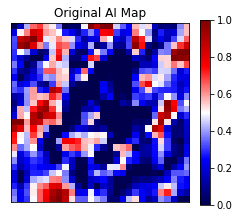

In [26]:
A_gsc_r_f   = np.reshape(ZI_s[feature_selected], (28*28, 1))                    #flatten
A_gsc_r_f_c = A_gsc_r_f - np.expand_dims(np.mean(x_train_f, axis=1), axis=1)    #center
print('Image shape:', A_gsc_r_f_c.shape)

# Plot the processed 2D map
plt.figure(figsize=(4, 4))
plt.imshow(np.reshape(A_gsc_r_f_c, (28, 28)), vmin=0, vmax=1,
           cmap=my_maps[features.index(feature_selected)])
plt.title('Original '+feature_selected+' Map'); plt.xticks([]); plt.yticks([])
plt.colorbar(shrink=0.85)
plt.show();

Try reconstructing the image from the latent variable of MNIST to a full 2D subsurface reservoir property map using a few different $k$'s, where $k$ is the size of the latent vector.

Note that we project our image *A_gsc_r_f_c* onto the precomputed left-singular vectors of the MNIST matrix $\tilde{U}$. This is projecting our image onto the generic latent space $z_{MNIST}$.

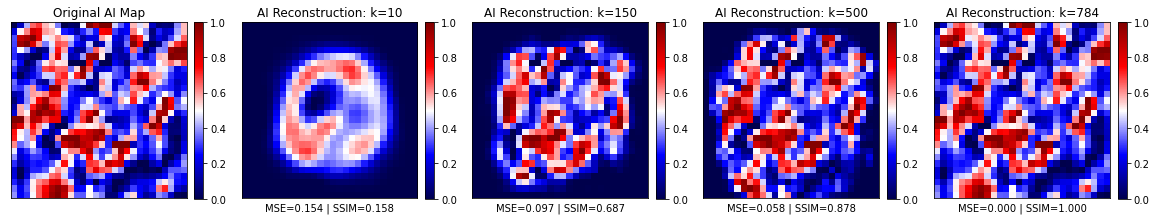

In [27]:
ks = [10, 150, 500, 784]

plt.figure(figsize=(len(ks)*5,4))

plt.subplot(1,len(ks)+1,1)
plt.imshow(ZI_s[feature_selected], cmap=my_maps[features.index(feature_selected)])
plt.title('Original '+feature_selected+' Map')
plt.colorbar(fraction=0.046, pad=0.04); plt.xticks([]); plt.yticks([])

for i in np.arange(len(ks)):
    v = (np.linalg.pinv(U[:, :ks[i]]) @ A_gsc_r_f_c).T  #project image onto latent space
    A_gsc_r_f_c_hat = U[:, :ks[i]] @ v.T
    A_gsc_r_f_hat   = A_gsc_r_f_c_hat + np.expand_dims(np.mean(x_train_f, axis=1), axis=1)
    A_gsc_r_hat     = np.reshape(A_gsc_r_f_hat.T, [-1, 28, 28])
    
    mse  = mean_squared_error(A_gsc_r_f_c, A_gsc_r_f_c_hat)
    ssim = SSIM(ZI_s[feature_selected], A_gsc_r_hat.squeeze())

    plt.subplot(1,len(ks)+1,i+2)
    img = plt.imshow(np.squeeze(A_gsc_r_hat), vmin=0, vmax=1,
                     cmap=my_maps[features.index(feature_selected)])
    plt.title(feature_selected+' Reconstruction: k='+ str(ks[i]))
    plt.xlabel('MSE={:.3f} | SSIM={:.3f}'.format(mse, ssim))
    plt.colorbar(fraction=0.046, pad=0.04); plt.xticks([]); plt.yticks([])
    
plt.show();

We can see that using only $k=10$ bases, we obtain basically approximately a digit $0$, corresponding to our MNIST latent space representation! Using too few (unrelated/generic) bases will give us a bad reconstruction.

However, we obtain really good MSE and SSIM for the reconstructions, even when using just a few more bases of the singular vectors. We get (almost) perfect reconstruction when we use (almost) all of the bases.

If we were to apply SVD to the subsurface image itself and then reconstruct it using a few of its own bases (like we did previously with the MNIST example), then we would obtain a great reconstruction with very few tailored bases. This example however shows the power of using a pre-trained decomposition matrix on a new subsurface image to reconstruct with small errors and low computational costs (e.g., transfer learning).

***

### 4. b) Dictionary Learning

With dictionary learning, we attempt to find a "dictionary" or "set of atoms" that performs well at sparsely encoding the fitted data. Essentially, this is a method for sparse encoding of our data, such that we can create a dictionary, or a repertoire of models, from which we can selectively choose a few representative samples to best predict a new data, thus promoting sparsity in the encoding. We use a linear combination of the "words" or "elements" or "atoms" in the dictionary. 

Dictionary Learning has direct relationship with Compressed Sensing and Sparse Coding, where a high-dimensional signal can be reconstructed with only a few linear measurements of the data assuming that the signal is relatively sparse. Regarding this branch of signal processing theory, one can for instance use Fourier or Wavelet Transforms are generic bases to create a sparse encoding of the data; however, Dictionary Learning provides tailored basis unique to the fitted/training data in order to provide the best sparse encoding. 

Mathematically: Given an input dataset $ X = [x_1, x_2, ..., x_k], \forall{x} \in \mathbb{R^d} $ we will find a Dictionary $ \mathbf{D} \in \mathbb{R}^{(d\times n)} := [d_1, d_2, ..., d_n] $ and a Representation vector $ R = [r_1, r_2, ..., r_k], r_i \in \mathbb{R}^n $ such that $ \|{X-\mathbf{D}R}\|_F^2 $ is minimized and the representations $r_i$ are sparse enough. As an optimization problem:
$$ (U^*,V^*) = \min_{ D\in{C}; r_i\in{\mathbb{R}^n} } {\sum\limits_{i=1}^{k} \|x_i- \mathbf{D}r_i\|_2^2 + \lambda\|r_i\|_0} $$ 
$$ \text{subject to:} \text{        } \lambda > 0 \text{   ,   } C\equiv {\{\mathbf{D}\in{\mathbb{R}^{(d\times n)}} : \|d_i\|_2 \leq 1, \forall{i}\in[1,n] \}}$$
where $(U^*,V^*)$ denote the components of the dictionary. Also, $\|\bullet\|_F$ denotes the Frobenius norm, $C$ constrains $\mathbf{D}$ so its atoms don't become arbitrarily large so $r_i$ is not arbitrarily small, and $\lambda$ controls the trade-off between sparsity and error minimization. In general, this problem is NP-hard and sometimes unsolvable due to the $l_0$ norm in the penalty term, and can be solved by convex relaxation from Compressed Sensing using the $l_1$ norm instead to ensure sparsity (this is the default implementation in *sklearn*).

This problems leads to many possible numerical solution schemes, including the LASSO or $l_1$ regularization mentioned above. Another solution scheme is through the $k$-SVD algorithm, where we update the atoms of the dictionary one by one. This can be thought of as a generalization of $k$-Means clustering algorithm, where we enforce each input data $x_i$ to be encoded by a linear combination of not more than $T_0$ elements in a way such that:
$$ \min_{\mathbf{D},R} \|X-\mathbf{D}R\|_F^2 $$
$$ \text{subject to:} \text{        } \|r_i\|_0 \leq T_0, \forall{i}$$
With this, we are fixing the first dictionary generated, finding the best possible $R$ given the constraint, and then iteratively updating the atoms of dictionary $\mathbf{D}$ as denoted below:
$$ \|X-\mathbf{D}R\|_F^2 = \lvert X-\sum\limits_{i=1}^{k} d_ix_T^i\rvert _F^2 = \|E_k-d_kx_T^k\|_F^2 $$
where at each step we compute the rank-$1$ approximation of the residual matrix $E_k$, update $d_k$, and enforce sparsity of $x_k$.

In general, choosing a tailored dictionary for a dataset is a non-convex problem, and $k$-SVD operates iteratively which does not guarantee convergence to the global optimum. 

We also take advantage that this technique is posed as an optimization problem, and utilize the Mini-Batch version in *sklearn* to improve computational efficiency and reduce timing. Essentially, at each iteration we only use a small subset of the training data to try and solve the optimization problem. This introduces stochasticity and accelerates the iterations by having more but smaller and quicker runs per iteration. 

For this implementation of Dictionary Learning, we consider the following hyperparameters:
- *n_components*: the number of dictionary elements to extract 
- *alpha*: sparsity controlling parameters ($\lambda$) {default=1}

! fair warning: fitting the dictionary learner may take up to a minute or two

In [28]:
# Instatiate and fit the model to generic (MNIST) training data
n_atoms = 120

#DL         = DictionaryLearning(n_components=n_atoms, alpha=2)
DL         = MiniBatchDictionaryLearning(n_components=n_atoms, alpha=2, batch_size=10, n_jobs=4)
dictionary = DL.fit(x_train_f_c.T, y_train)
atoms      = dictionary.components_

print('Dictionary Shape={} | Iterations={}'.format(atoms.shape, dictionary.n_iter_))

Dictionary Shape=(120, 784) | Iterations=1000


Below, we visualize the Dictionary that we created. 

We see that some digits are very nicely encoded, while other digits not so much and some digits are even missing from the encoding. This is highly dependent on the sparsity parameter selected ($\alpha$, a.k.a. $\lambda$). However, this dictionary can still be used to reconstructed the original dataset.

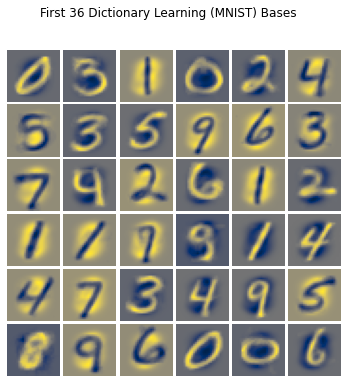

In [29]:
n_display_atoms = 36
atoms_   = np.reshape(atoms, (-1, x_train.shape[1], x_train.shape[2], 1)) #reshape dictionary
atoms_k_ = atoms_[:n_display_atoms,:]    #select only a few atoms to visualize

plot_sample_matrix(atoms_k_, my_cmap='cividis')
plt.suptitle('First '+str(n_display_atoms)+' Dictionary Learning (MNIST) Bases')
plt.show();

Below we can compare the latent space representations on the first 2D projection for the SVD decomposition and the sparse Dictionary Learning representation of the MNIST data.

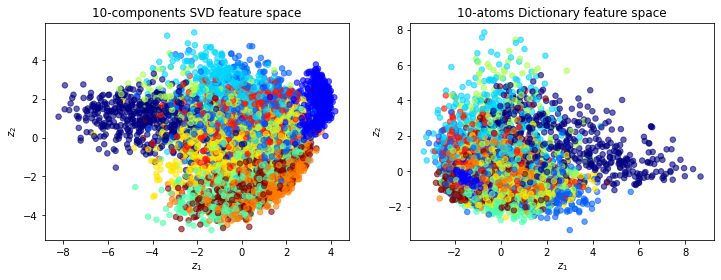

In [30]:
# Project the training data
zDL  = x_train_f_c.T @ atoms.T 
zSVD = x_train_f_c.T @ U[:,:n_atoms]

# Visualize feature space projections
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(zSVD[:,0], zSVD[:,1], s=30, c=cs, alpha=0.6)
plt.title('10-components SVD feature space')
plt.xlabel('$z_1$'); plt.ylabel('$z_2$')
plt.subplot(122)
plt.scatter(zDL[:,0], zDL[:,1], s=30, c=cs, alpha=0.6)
plt.title('10-atoms Dictionary feature space')
plt.xlabel('$z_1$'); plt.ylabel('$z_2$')
plt.show();

Using the learned dictionary, we can then reconstruct images through the *SparseCoder* function, which takes the learned dictionary and finds the sparse representation of the data against it. With this, each row of the product is a solution of the sparse coding proble, and the algorithm fides the optimal code such that: $ X \approx \hat{X} = Code * Dictionary $. Thus, let's denote it as:
$$ \hat{X} = \Phi * D $$

In [31]:
# Generate the sparse encoder and project onto the atoms of the dictionary
sparse_code = SparseCoder(atoms).fit_transform(x_train_f_c.T, y_train)
sparse_recs = (atoms.T @ sparse_code.T)
print('Sparse Encoder shape = {}'.format(sparse_code.shape))
print('Sparse Reconstruction dictionary shape = {}'.format(sparse_recs.shape))

Sparse Encoder shape = (5000, 120)
Sparse Reconstruction dictionary shape = (784, 5000)


Next, we have to restore the reconstruction by uncentering and unflattening the vectors into images, and below we plot a few of the original MNIST training images against the sparse Dictionary Learning reconstructions.

In [32]:
DL_img_f_hat = sparse_recs + np.expand_dims(np.mean(x_train_f, axis=1), axis=1)    #uncenter
DL_img_hat   = np.reshape(DL_img_f_hat.T, [-1, 28, 28])                            #unflatten

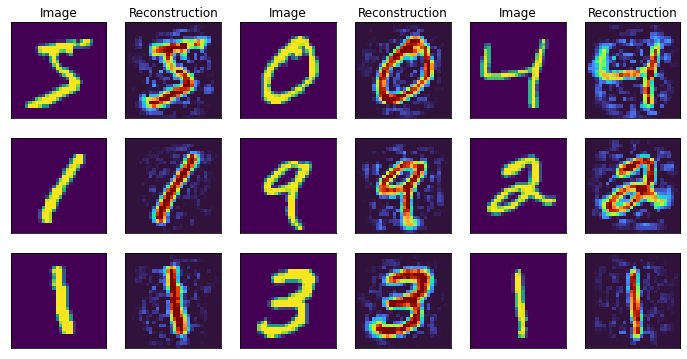

In [33]:
num_rows, num_cols = 3, 3
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_rows*num_cols):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plt.grid(False); plt.xticks([]); plt.yticks([])
    plt.imshow(x_train[i], vmin=0, vmax=1, cmap='viridis')
    if i < 3: plt.title('Image')
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plt.grid(False); plt.xticks([]); plt.yticks([])
    plt.imshow(DL_img_hat[i], vmin=0, vmax=1, cmap='turbo')
    if i < 3: plt.title('Reconstruction')
plt.show();

We now have predicted images $\hat{x}$ for our MNIST dataset. Essentially, the decoded images from a sparse dictionary representation of the MNIST training set. We will visualize these reconstructed images, and compare their quality by means of pixel-wise MSE and SSIM. For MSE calculation, we will use the flattened, centered arrays $N \times M$ as opposed to the images $N \times (M,D)$ used in the SSIM calculation.

We see an extremely good MSE and SSIM, so the reconstructed images from the sparse dictionary are quite good!

In [34]:
# Error Metrics for selected level of k
mse  = mean_squared_error(x_train_f_c, sparse_recs)
ssim = SSIM(x_train.squeeze(), DL_img_hat)
print('MSE={:.3f} | SSIM={:.3f}'.format(mse,ssim))

MSE=0.008 | SSIM=0.926


**Subsurface Dictionary Learning:**

The next step is to use this sparse dictionary from MNIST to try to reconstruct our subsurface quantity of interest. Again, this is testing the limit of our autoencoder structure, and the limits of the latent space representation of a generic dataset to reconstruct a new, unrelated image (e.g., transfer learning).
This can be written as:
$$ \hat{X}_{subsurface} = \Phi_{subsurface} * D_{generic} $$
where $D_{generic}$ is the learned dictionary from MNIST data, and $\Phi_{subsurface}$ is the optimal sparse coder for the subsurface image using the learned generic dictionary.

In [35]:
sparse_code_subsurf = SparseCoder(atoms).fit_transform(A_gsc_r_f_c.T)
sparse_rec_subsurf  = atoms.T @ sparse_code_subsurf.T
print('Subsurface Sparse Encoder shape = {}'.format(sparse_code_subsurf.shape))
print('Subsurface Sparse Reconstruction shape = {}'.format(sparse_rec_subsurf.shape))

Subsurface Sparse Encoder shape = (1, 120)
Subsurface Sparse Reconstruction shape = (784, 1)


Let's uncenter and unflatten the reconstructed subsurface image, and visualize the result. We can also compare to the true subsurface image and compute the MSE and SSIM from the reconstruction to the true image.

In [36]:
sparse_rec_subsurf_f   = sparse_rec_subsurf + np.expand_dims(np.mean(x_train_f, axis=1), axis=1)  #uncenter
sparse_rec_subsurf     = np.reshape(sparse_rec_subsurf_f.T, [-1,28,28])                           #unflatten

In [37]:
# Compute MSE and SSIM
mse  = mean_squared_error(A_gsc_r_f_c, sparse_rec_subsurf_f)
ssim = SSIM(ZI_s[feature_selected], sparse_rec_subsurf.squeeze())
print('MSE={:.3f} | SSIM={:.3f}'.format(mse, ssim))

MSE=0.146 | SSIM=0.604


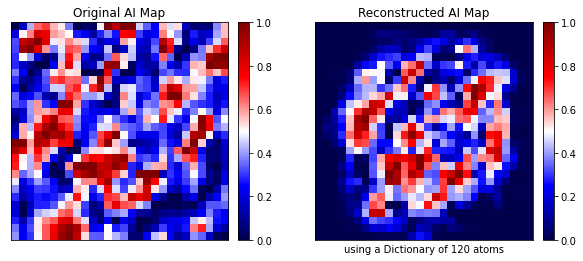

In [38]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.imshow(ZI_s[feature_selected], cmap=my_maps[features.index(feature_selected)])
plt.title('Original '+feature_selected+' Map')
plt.colorbar(fraction=0.046, pad=0.04); plt.xticks([]); plt.yticks([])

plt.subplot(122)
plt.imshow(sparse_rec_subsurf.squeeze(), vmin=0, vmax=1,
           cmap=my_maps[features.index(feature_selected)])
plt.title('Reconstructed '+feature_selected+' Map')
plt.xlabel('using a Dictionary of '+str(n_atoms)+' atoms')
plt.colorbar(fraction=0.046, pad=0.04); plt.xticks([]); plt.yticks([])

plt.show();

Here we can clearly see that the usage of a generic basis to reconstruct a subsurface map is not so efficient, at least due to the fact the we only used $n$ atoms in the dictionary. Increasing the number of atoms can help in improving this prediction, but at a greater computational cost. The alternative was to implement MiniBatchDictionaryLearning instead for improved computational efficiency.

Nonetheless, we see that there is at least a possible reconstruction for the subsurface variable of interest by using a pre-trained encoder basis. We see that the main structures near the center are preserved, and the overall MSE and SSIM are not too bad. Promising!

***

### Results and Discussion

SVD:
- SVD is very widely-used and can be applied to a large set of problems in science and engineering, incuding 1D problems like time-series analysis, 2D/3D problems such as subsurface images/volumnes, and dynamic problems (via POD/DMD) such as reservoir simulation. It has been used to find pseudo-inverses, solving linear equations, and of course dimensionality reduction.
- SVD can serve as a mathematical formulation for PCA if we decompose the centered covariance matrix and truncating less important basis vectors.
- The economy SVD implementation (where zero singular values and vectors are truncated) is quite cheap in numpy.linalg. We can use this for a large-scale problem without much computational effort and it is very useful for a wide set of applicaitons.

Dictionary Learning:
- If we iteratively perform SVD on a set of images to find the one image that best encodes a subset of the data, and repeat until we find a set of atoms/words that encodes all subsets of the data, we have now arrived at a dictionary! This is Dictionary Learning, where we sparsely represent a set of vectors to provide a sparse representation of a given signal. 
- SVD is used in the optimization formulation under orthonormality constraint to find this optimal dictionary. We call this the k-SVD algorithm - a greedy prodcedure composed of two stages: Sparse Coding and Dictionary Update. The solution yields our sparse learned dictionary of atoms.
- We then combine a set of the atoms in the Dictionary to best (sparsely) represent the new image, thus reducing the dimensionality of the problem.


Important Notes:
- The MNIST dataset has the digits centered at the image. Therefore, we using the learned basis from this generic dataset, our subsurface image reconstructions will be most accurate near the center and quite bad near the edges. If we increase the dimension of the latent space, we start to gather information of the edges (which is irrelevant for MNIST but relevant for subsurface maps). Therefore, for this particular transfer learning problem, we might need to use more latent variables than desired. Using a different generic dataset with more information near the edges to learn the sparse encoding might help in transfer reconstruction.

- Dictionary Learning is set up as an optimization problem, therefore using the entire dataset at each iteration of the numerical optimization is extremely expensive (especially for MNIST that has 60,000 instances). The implementation of MiniBatch Dictionary Learning allows for stochastic optimization with small batches of the training data at each iteration. This is extremely useful for our purpose, where we are mostly interested in the application and visualization of the method. For research-caliber results, implement full dictionary with the full training data set.

MNIST:
- Using SVD, we see that approximately 60 latent variables will suffice to encode the MNIST images (28x28=784) with 50% of the energy conserved. Alternatively, 80% energy would require approximately 220 latent variables. Nonetheless, for MNIST compression and reconstruction, our experiment shows that 36 latent variables are sufficient to obtain a very good MNIST reconstruction, with approximately MSE=0.01 and SSIM=0.85! 

- With Dictionary Learning, we see that approximately 120 atoms/words are enough to construct a good dictionary that can be used to reconstruct our images. With a mildly-strong penalty parameter and a MiniBatch optimization implementation, we obtain a set of atoms that yields MNIST compression and reconstruction with MSE=0.1 and SSIM=0.9!

Subsurface:
- With SVD we obtained a set of left-singular vectors, singular values, and right-singular vectors, all from our training MNIST images. Using a subset of these vectors, we then projected our subsurface image onto it, thus reducing the dimensionality. Using the inverse decomposition we could then reconstruct this compressed subsuface image, and saw that using only 10 singular values our SSIM was about 0.1, using 150 singular values our SSIM was 0.6, and using 500 singular values our SSIM was 0.8. Using all singular values (k=784), our SSIM was 1.00. Therefore, we can say that transfer learning with extreme dimensionality reduction using SVD is not so good for reconstruction, and we actually need to maintain a large number of singular values to actually obtain a good result. Nonetheless, computational complexity and costs are really low for this technique.

- Using our Dictionary from MNISt images with 120 atoms, we encoded and reconstructed our subsurface image. Again, we see the problem that the borders are not accurately portrayed, and our MSE was 0.2 but our SSIM was 0.5. This is not a bad reconstruction, but it is not good either. The main issue occurs at the edges, where the MNIST basis do not have a lot of information, and were our subsurface reconstruction fades, but it shouldn't, and therefore limits our technique. 

Conclusions:
- Singular Value Decomposition and Dictionary Learning are two very powerful and useful techniques for dimensionality reduction and image compression/reconstruction problems. They can also be used for other latent space applications such as clustering, parameter estimation, and more.

- MSE and SSIM provide useful measures for the goodness-of-fit and validity of our reconstructions. SSIM is especially useful when dealing with image datasets, and compares the mean and variance of a set of prior and posterior images. We see that for our experiment, MSE is low and SSIM is high when we try to reconstruct MNIST images from a latent dimension using MNIST basis, but we see medium MSE and SSIM (acceptable but not excellent) when reconstructing subsurface images from MNIST basis.

### References:
1. R. Tavakoli and A. C. Reynolds. "History Matching With Parameterization Based on the Singular Value Decomposition of a Dimensionless Sensitivity Matrix." SPE J. 15 (2010): 495–508. doi: 10.2118/118952-PA
2. S. Afra, and E. Gildin. "Tensor based geology preserving reservoir parameterization with Higher Order Singular Value Decomposition (HOSVD)." Computers & Geosciences 94 (2016): 110-120. doi: 10.1016/j.cageo.2016.05.010
3. Etienam C., Velasquez R.V., Dorn O. (2019). Sparse Multiple Data Assimilation with K-SVD for the History Matching of Reservoirs. In: Faragó I., Izsák F., Simon P. (eds) Progress in Industrial Mathematics at ECMI 2018. Mathematics in Industry, vol 30. Springer.
4. P. Sprechmann and G. Sapiro, "Dictionary learning and sparse coding for unsupervised clustering," IEEE International Conference on Acoustics, Speech and Signal Processing, (2010): pp. 2042-2045. doi: 10.1109/ICASSP.2010.5494985. 

5. Brunton, S., & Kutz, J. (2019). Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control. Cambridge: Cambridge University Press.
6. Murphy, K. P. (2012). Machine Learning: A Probabilistic Perspective. United States: MIT Press.
7. Phillips, J. M. (2021). Mathematical Foundations for Data Analysis. Germany: Springer International Publishing.
8. Verleysen, M., Lee, J. A., Lee, J. A. (2007). Nonlinear Dimensionality Reduction. Netherlands: Springer New York.
9. Wang, J. (2012). Geometric Structure of High-Dimensional Data and Dimensionality Reduction. Germany: Higher Education Press.

***

### About Me

I am currently a PhD student in Petroleum & Geosystems Engineering at The University of Texas at Austin, and I am supervised by Drs. Pyrcz and Torres-Verdin. My background is in Petroleum Engineering & Applied Mathematics from the University of Tulsa. I am originally from Venezuela!

At UT, I am working on the computational description of subsurface energy and environmental systems. I combine domain-specific knowledge with tools from machine learning & deep learning, math and statistics, for accurate characterization and forecasting of complex dynamical systems in the subsurface. My work is centered on integrated applied energy data analytics by developing novel technologies, practical workflows, demos and documentation to support the digital revolution in energy. My focus is on machine learning and data science applications for subsurface modeling and simulation, including: uncertainty quantification, inverse modeling, data assimilation, control & optimization, and physics-informed predictive analytics.


* More workflows to come on other advanced dimensionality reduction techniques!
    * PCA/kPCA, tSNE, DFT/DCT/DWT, POD/DMD, Deep Learning-based AutoEncoders, ... 
* Also working on subsurface problems including machine learning & data science applications for reservoir modeling & simulation.
    * Uncertainty quantification, data assimilation, control & optimizaiton, inverse & reduced-order modeling! 

I hope this was helpful,

**Misael M. Morales**

misaelmorales@utexas.edu
#### [GitHub](https://github.com/misaelmmorales) | [Website](https://sites.google.com/view/misaelmmorales) | [LinkedIn](https://www.linkedin.com/in/misaelmmorales)

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin


# END